In [29]:
import numpy

In [30]:
%matplotlib inline

import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib

In [31]:
# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.
data = pd.read_csv('~/Downloads/kddcup.csv', low_memory=False)

In [32]:

# extract just the logged-in HTTP accesses from the data
type(data)
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.00,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.00,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.00,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.00,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.00,0.0,normal.
5,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.00,0.0,normal.
6,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.00,0.00,0.00,0.0,normal.
7,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.00,0.00,0.00,0.0,normal.
8,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.00,0.00,0.00,0.0,normal.
9,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.00,0.00,0.00,0.0,normal.


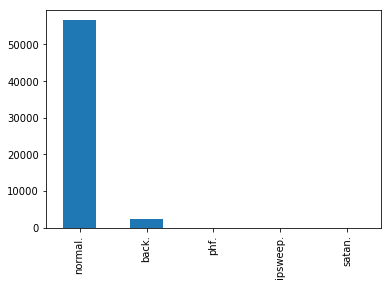

In [33]:
# extract just the logged-in HTTP accesses from the data
data = data[data['service'] == "http"]  
data = data[data["logged_in"] == 1]

# let's take a look at the types of attack labels are present in the data.
data.label.value_counts().plot(kind='bar')

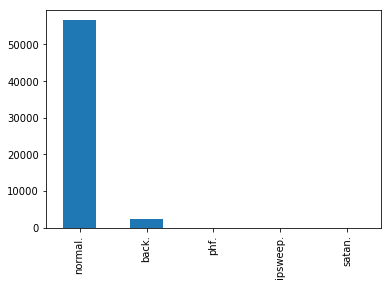

In [34]:
# the full dataset contains features for SMTP, NDP, ICMP, etc.
# here we'll grab just the relevant features for HTTP.
relevant_features = [  
    "duration",
    "src_bytes",
    "dst_bytes",
    "label"
]

# replace the data with a subset containing only the relevant features
data = data[relevant_features]

# normalise the data - this leads to better accuracy and reduces numerical instability in
# the SVM implementation
data["duration"] = np.log((data["duration"] + 0.1).astype(float))  
data["src_bytes"] = np.log((data["src_bytes"] + 0.1).astype(float))  
data["dst_bytes"] = np.log((data["dst_bytes"] + 0.1).astype(float))  
data.label.value_counts().plot(kind='bar')


In [35]:
# we're using a one-class SVM, so we need.. a single class. the dataset 'label'
# column contains multiple different categories of attacks, so to make use of 
# this data in a one-class system we need to convert the attacks into
# class 1 (normal) and class -1 (attack)
data.loc[data['label'] == "normal.", "attack"] = 1  
data.loc[data['label'] != "normal.", "attack"] = -1

# grab out the attack value as the target for training and testing. since we're
# only selecting a single column from the `data` dataframe, we'll just get a
# series, not a new dataframe
target = data['attack']

# find the proportion of outliers we expect (aka where `attack == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])

# drop label columns from the dataframe. we're doing this so we can do 
# unsupervised training with unlabelled data. we've already copied the label
# out into the target series so we can compare against it later.
data.drop(["label", "attack"], axis=1, inplace=True)

# check the shape for sanity checking.
data.shape  

outliers.shape (2209,)
outlier fraction 0.03761600681140911


(58725, 3)

In [36]:
from sklearn.cross_validation import train_test_split  
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape 

(46980, 3)

In [37]:
# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0])/target.shape[0]
print("nu", nu)

nu 0.03761600681140911


In [38]:
from sklearn import svm
model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  
model.fit(train_data) 

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.03761600681140911, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [39]:
from sklearn import metrics  
preds = model.predict(train_data)  
targs = train_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

accuracy:  0.977352064708
precision:  0.998802286954
recall:  0.977637196134
f1:  0.988106416275
area under curve (auc):  0.973855300495


In [40]:
preds = model.predict(test_data)  
targs = test_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds)) 

accuracy:  0.980076628352
precision:  0.998738852356
recall:  0.980543026444
f1:  0.989557300964
area under curve (auc):  0.974289778062


In [41]:
data = pd.read_json(some_json)  
model.predict(data)  

NameError: name 'some_json' is not defined